In [1]:
import numpy as np

from dynamic_coding_analysis.analysis_pipeline import get_data
from dynamic_coding_analysis.analysis_pipeline import process_spikes as spk

import matplotlib.pyplot as plt
from matplotlib import gridspec

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

from tqdm import trange

C:\Users\ilow1\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# define sessions
base = 'G:/My Drive/Giocomo Lab/RandomForage/'
data_folder = base + 'aggregate_data/'
save_folder = base + 'Dynamic MEC Coding Project/fig2_images_supp/multi_maps/'

''' N maps = 3/4 '''
mice = ['Seattle', 'Juneau', 'Toronto', 'Kerala']
sessions = [['1006_1', '1010_1'], 
            ['1102_1', '1104_1', '1105_1'], 
            ['1111_1', '1117_1'],  
            ['1207_1', '1213_1']]

print('N mice: ' + str(len(mice)))
N_sessions = 0
for s in sessions:
    N_sessions += len(s)
print('N sessions: ' + str(N_sessions))

# make a dict to hold data
data = {}
for session, m in zip(sessions, mice):
    data[m] = {}
    for s in session:
        data[m][s] = {}

N mice: 4
N sessions: 9


In [3]:
# load the data
from pathlib import Path

N_cells = 0
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        d['Y'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_FRtensor.npy')
        d['B'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_spikes.npy')
        d['A'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_behavior.npy')  
        d['cells'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_cellIDs.npy')
        
        # filter sessions with deleted AP/ML cells
        filt_file = data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_idx.npy'
        if Path(filt_file).exists():
            print(m + '_' + s + ' corrected for mistargeting')
            cell_idx = np.load(filt_file)
            d['cells'] = d['cells'][cell_idx]
            d['Y'] = d['Y'][:, :, cell_idx]
            d['B'] = d['B'][:, cell_idx]
        
        N_cells += d['cells'].shape[0]

In [4]:
# calculate similarity score across trials
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        sim_vec = np.abs(pdist(Y_unwrapped, 'correlation')-1)
        sim = squareform(sim_vec)
        d['similarity'] = sim

In [5]:
''' K-MEANS '''
from lvl.factor_models import KMeans as lvl_kmeans
from lvl.factor_models import NMF as lvl_soft_kmeans
from scipy.spatial.distance import cdist 
from scipy.special import logsumexp
def softmax(M):
    return np.exp(M - logsumexp(M, axis=-1, keepdims=True))

In [ ]:
''' try 3-factor kmeans '''
N = 3
model_kmeans = lvl_kmeans(n_components=N, n_restarts=30)
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        
        # fit model and get params
        model_kmeans.fit(Y_unwrapped)
        W, H = model_kmeans.factors
        Y_hat = model_kmeans.predict()
        d['kmeans'] = {}
        d['kmeans']['W'] = W
        d['kmeans']['H'] = H
        d['kmeans']['Y_hat'] = Y_hat  

In [ ]:
''' see how k-means fits '''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A']
        gs = gridspec.GridSpec(15, 1, hspace=1.5)
        f = plt.figure(figsize=(2, 3))

        # get clim for similarity
        sim = d['similarity']
        clims = [0.2, 0.8]

        # plot Euclidean similarity score
        ax1 = plt.subplot(gs[:11])
        im = ax1.imshow(sim, clim=clims, aspect='auto', cmap='Greys')
        ax1.tick_params(labelbottom=False)
        ax1.set_ylabel('trial number')
        ax1.set_title(m + '_' + s)
        
         # plot cluster occupancy
        W = d['kmeans']['W']
        ax0 = plt.subplot(gs[11:-1])
        ax0.plot(W, lw=1)
        ax0.set_xlim([0, sim.shape[0]])
        ax0.set_ylim([-0.2, 1.2])
        ax0.set_ylabel('map')
        ax0.set_xlabel('trial number')
        
        plt.show()

In [8]:
''' try 4-factor kmeans '''
N = 4
model_kmeans = lvl_kmeans(n_components=N, n_restarts=30)
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        
        # fit model and get params
        model_kmeans.fit(Y_unwrapped)
        W, H = model_kmeans.factors
        Y_hat = model_kmeans.predict()
        d['kmeans'] = {}
        d['kmeans']['W'] = W
        d['kmeans']['H'] = H
        d['kmeans']['Y_hat'] = Y_hat  

c:\users\ilow1\documents\python scripts\lvl\lvl\factor_models\kmeans.py:282: RuntimeWarning: invalid value encountered in subtract
  np.linalg.norm(centroids - last_centroids) /


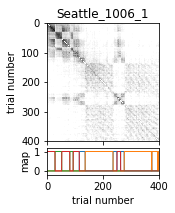

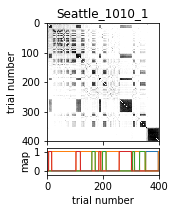

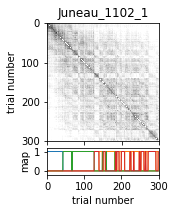

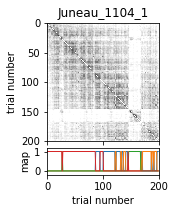

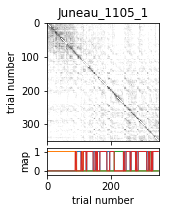

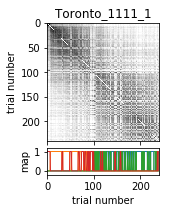

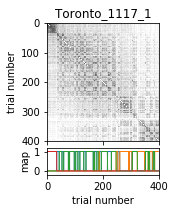

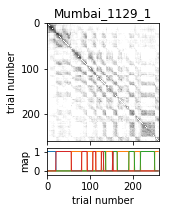

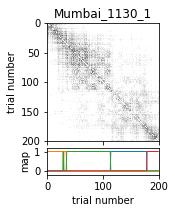

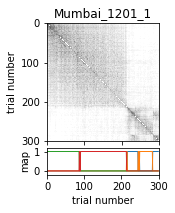

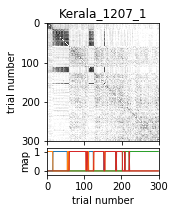

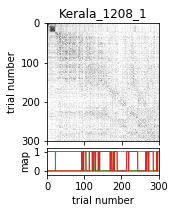

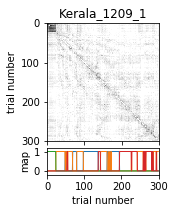

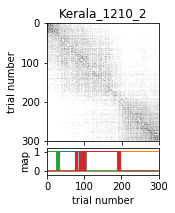

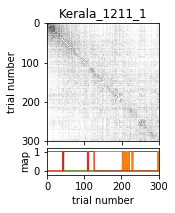

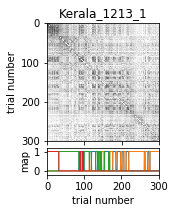

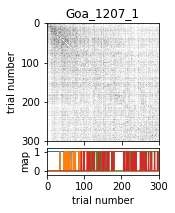

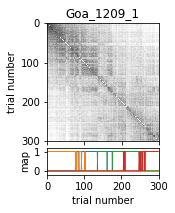

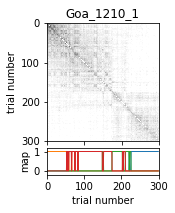

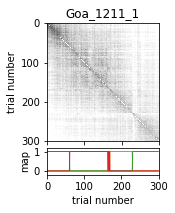

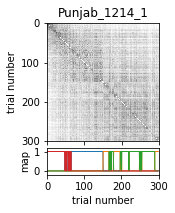

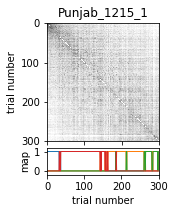

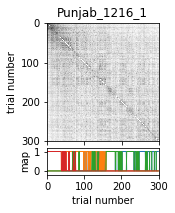

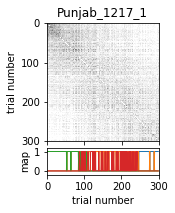

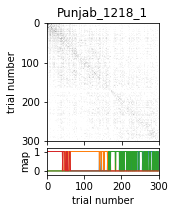

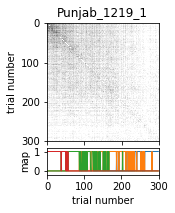

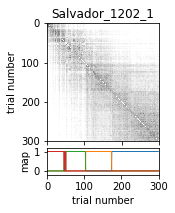

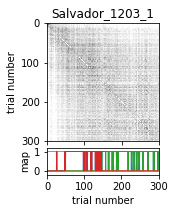

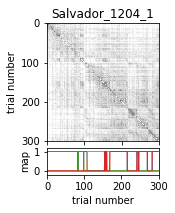

In [9]:
''' see how k-means fits '''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A']
        gs = gridspec.GridSpec(15, 1, hspace=1.5)
        f = plt.figure(figsize=(2, 3))

        # get clim for similarity
        sim = d['similarity']
        clims = [0.2, 0.8]

        # plot Euclidean similarity score
        ax1 = plt.subplot(gs[:11])
        im = ax1.imshow(sim, clim=clims, aspect='auto', cmap='Greys')
        ax1.tick_params(labelbottom=False)
        ax1.set_ylabel('trial number')
        ax1.set_title(m + '_' + s)
        
         # plot cluster occupancy
        W = d['kmeans']['W']
        ax0 = plt.subplot(gs[11:-1])
        ax0.plot(W, lw=1)
        ax0.set_xlim([0, sim.shape[0]])
        ax0.set_ylim([-0.2, 1.2])
        ax0.set_ylabel('map')
        ax0.set_xlabel('trial number')
        
        plt.show()

In [6]:
''' N maps = 3/4 '''
mice = ['Seattle', 'Juneau', 'Toronto', 'Kerala']
sessions = [['1006_1', '1010_1'], 
            ['1102_1', '1104_1', '1105_1'], 
            ['1111_1', '1117_1'], 
            ['1213_1']]
mice_IDs = ['6a', '6c', '7b', '9b']

In [7]:
three_maps = ['Seattle_1010_1', 
              'Juneau_1102_1', 'Juneau_1104_1', 'Juneau_1105_1', 
              'Toronto_1111_1']
four_maps = ['Seattle_1006_1', 'Toronto_1117_1', 'Kerala_1213_1']

In [86]:
'''
Assign colors based on track type
see: https://personal.sron.nl/~pault/#sec:qualitative Fig. 4
cue poor : green
cue rich : rose
'''
cp_color = [17/255, 119/255, 51/255, 1]
cr_color = [204/255, 102/255, 119/255, 1]

# cell_colors = indigo, black/gray, sand, teal
cell_colors = [[51/255, 34/255, 136/255, 1], 'k', 
               [221/255, 204/255, 119/255, 1], [68/255, 170/255, 153/255, 1]]
all_map_colors = [[51/255, 34/255, 136/255, 1],
                  [150/255, 150/255, 150/255, 1],
                  [221/255, 204/255, 119/255, 1],
                  [68/255, 170/255, 153/255, 1]]

In [73]:
for m, session in zip(mice, sessions):
    for s in session:
        if '{}_{}'.format(m, s) in four_maps:
            N = 4
            model_kmeans = lvl_kmeans(n_components=N, n_restarts=100)
        else:
            N = 3
            model_kmeans = lvl_kmeans(n_components=N, n_restarts=100)
        
        d = data[m][s]
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        
        # fit model and get params
        model_kmeans.fit(Y_unwrapped)
        W, H = model_kmeans.factors
        Y_hat = model_kmeans.predict()
        d['kmeans'] = {}
        d['kmeans']['W'] = W
        d['kmeans']['H'] = H
        d['kmeans']['Y_hat'] = Y_hat  

c:\users\ilow1\documents\python scripts\lvl\lvl\factor_models\kmeans.py:282: RuntimeWarning: invalid value encountered in subtract
  np.linalg.norm(centroids - last_centroids) /


In [126]:
''' save remap index: '''
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        W = d['kmeans']['W']
        trials = np.arange(0, W.shape[0]-1)

        # define remaps
        remap_idx = np.asarray([])
        for w in range(W.shape[1]):
            remaps = np.where(np.abs(np.diff(W[:, w])))[0]
            remap_idx = np.append(remap_idx, remaps)
        remap_idx = np.unique(remap_idx)
        d['remap_idx'] = remap_idx.astype(int)

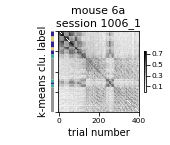

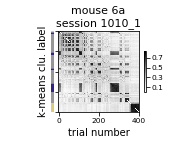

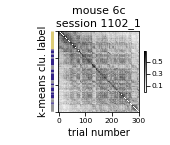

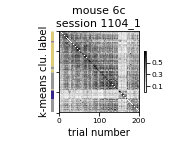

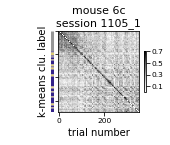

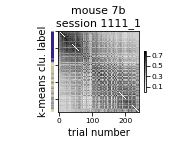

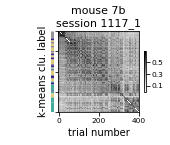

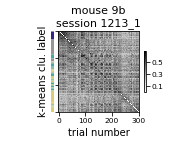

In [134]:
''' save k-means fit + similarity '''
CLU_W = 3
for i, m in enumerate(mice):
    session = sessions[i]
    m_ID = mice_IDs[i]
    for s in session:
        d = data[m][s]
        A = d['A']
        gs = gridspec.GridSpec(1, 10, hspace=1.5)
        f = plt.figure(figsize=(2, 1.5))

        # plot Euclidean similarity score
        ax1 = plt.subplot(gs[1:])
        sim = d['similarity']
        im = ax1.imshow(sim, aspect='auto', cmap='Greys')
        ax1.tick_params(labelleft=False)
        ax1.set_ylabel('k-means clu. label', labelpad=10)
        ax1.set_xlabel('trial number')
        ax1.set_title('mouse ' + m_ID + '\nsession ' + s, fontsize=11, pad=4)
        ax1.tick_params(which='major', labelsize=7.5, pad=2)
        
        #colorbar
        cbar = f.colorbar(im, shrink=0.5,
                          ticks=np.arange(0.1, 0.8, 0.2))
        cbar.ax.tick_params(labelsize=7.5, pad=2)
        
        # k-means cluster labels
        ax2 = plt.subplot(gs[0])
        remap_idx = d['remap_idx']
        W = d['kmeans']['W'].copy()
        start_idx = np.append([0], remap_idx)
        end_idx = np.append(remap_idx, W.shape[0])
        map_colors = []
        for i in np.where(W[remap_idx, :])[1]:
            map_colors.append(all_map_colors[i])
        map_colors.append(all_map_colors[np.where(W[-1, :])[0][0]])
        ax2.vlines(np.full(start_idx.shape[0], 1), start_idx, end_idx, 
                   colors=map_colors, lw=np.full(start_idx.shape[0], CLU_W), linestyles=np.full(start_idx.shape[0], 'solid'))
        ax2.set_xlim([0.5, 1.5])
        ax2.set_ylim([W.shape[0], 0])
        plt.axis('off')    
        ax2.set_ylabel('k-means cluster label')
        
        f.savefig(save_folder + m + '_' + s + '_similarity.png', dpi=400, bbox_inches='tight')
        plt.show()

In [80]:
''' get map indices '''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A'].copy()

        # get map indices
        W = d['kmeans']['W']
        trials = A[:, 2]
        n_maps = W.shape[1]
         
        map_idx = np.zeros([n_maps, trials.shape[0]])
        for i, t in enumerate(np.unique(trials)):
            for j in range(W.shape[1]):
                if W[i, j]:
                    map_idx[j, trials == t] = 1

        d['idx'] = map_idx.astype(bool)

In [88]:
''' single cell examples '''
m = 'Seattle'
s = '1010_1'
d = data[m][s]
cells = d['cells']

print('n cells = ' + str(cells.shape[0]))

n cells = 142


In [89]:
# Seattle
cell_IDs = [529, 528, 95] # Seattle_1010 example cells

In [90]:
# get FR in each map
A = d['A']
B = d['B']
dt = 0.02

# get map indices
W = d['kmeans']['W']
map0_idx = d['idx'][0, :].copy()
map1_idx = d['idx'][1, :].copy()
map2_idx = d['idx'][2, :].copy()

# get FR by position in each map + naive for all cells   
FR, binned_pos, FR_sem = spk.tuning_curve(A[:, 0], B, dt, b=2, SEM=True)
FR_0, binned_pos, FR_0_sem = spk.tuning_curve(A[map0_idx, 0], B[map0_idx, :], dt, b=2, SEM=True)
FR_1, binned_pos, FR_1_sem = spk.tuning_curve(A[map1_idx, 0], B[map1_idx, :], dt, b=2, SEM=True)
FR_2, binned_pos, FR_2_sem = spk.tuning_curve(A[map2_idx, 0], B[map2_idx, :], dt, b=2, SEM=True)

if '{}_{}'.format(m, s) in four_maps:
    map3_idx = d['idx'][3, :].copy()
    FR_3, binned_pos, FR_3_sem = spk.tuning_curve(A[map3_idx, 0], B[map3_idx, :], dt, b=2, SEM=True)

In [91]:
all_FR = np.zeros([FR_0.shape[0], FR_0.shape[1], W.shape[1]])
all_FR_sem = np.zeros([FR_0.shape[0], FR_0.shape[1], W.shape[1]])

all_FR[:, :, 0] = FR_0
all_FR[:, :, 1] = FR_1
all_FR[:, :, 2] = FR_2
if '{}_{}'.format(m, s) in four_maps:
    all_FR[:, :, 3] = FR_3
    
all_FR_sem[:, :, 0] = FR_0_sem
all_FR_sem[:, :, 1] = FR_1_sem
all_FR_sem[:, :, 2] = FR_2_sem
if '{}_{}'.format(m, s) in four_maps:
    all_FR_sem[:, :, 3] = FR_3_sem

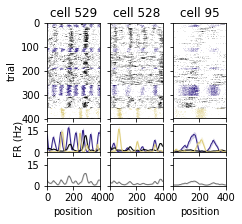

In [92]:
''' fig. 2g '''
gs = gridspec.GridSpec(5, 3, hspace=0.2)
f = plt.figure(figsize=(3.2, 3)) 
PT_SIZE = 1
LW_MEAN = 1
LW_SEM = 0.3

for i, cell_ID in enumerate(cell_IDs):
    # set axes
    ax0 = plt.subplot(gs[:3, i])
    ax1 = plt.subplot(gs[3:4, i])
    ax2 = plt.subplot(gs[4:, i])

    
    # cycle through maps
    for j in range(W.shape[1]):
        # draw raster
        map_idx = d['idx'][j, :].copy()
        sdx = B[map_idx, np.where(cells==cell_ID)[0][0]].astype(bool)
        ax0.scatter(A[map_idx, 0][sdx], A[map_idx, 2][sdx], color=cell_colors[j], lw=0, s=PT_SIZE, alpha=.1)
        
        # plot tuning curves with SEM
        sdx = (np.where(cells==cell_ID)[0][0]).astype(int)
        FR_map = np.squeeze(all_FR[:, :, j])
        sem_map = np.squeeze(all_FR_sem[:, :, j])
        ax1.plot(FR_map[:, sdx], color=cell_colors[j], lw=LW_MEAN, alpha=1)
        ax1.fill_between(binned_pos/2, FR_map[:, sdx] + sem_map[:, sdx], FR_map[:, sdx] - sem_map[:, sdx],
                         color=cell_colors[j], linewidth=LW_SEM, alpha=0.2)
    
    # plot naive tuning curve with SEM
    sdx = (np.where(cells==cell_ID)[0][0]).astype(int)
    ax2.plot(FR[:, sdx], 'k', lw=LW_MEAN, alpha=0.5)
    ax2.fill_between(binned_pos/2, FR[:, sdx] + FR_sem[:, sdx], FR[:, sdx] - FR_sem[:, sdx],
                     color='k', linewidth=LW_SEM, alpha=0.1)

    # format axes
    ax0.set_xlim((0, 400))
    ax0.set_xticks(np.arange(0, 425, 200))
    ax0.tick_params(labelbottom=False)
    ylim_ax = [0, np.max(A[:, 2])]
    ax0.set_ylim(ylim_ax[::-1])
    ax0.set_title('cell ' + str(cell_ID))
     
    if i == 0:
        ax0.set_ylabel('trial')
        ax1.set_ylabel('FR (Hz)')
    else:
        ax0.tick_params(labelleft=False)
        ax1.tick_params(labelleft=False)
        ax2.tick_params(labelleft=False)
        
    ax1.set_xlim([0, 200])
    ax1.set_ylim([0, 20])
    ax1.set_xticks(np.arange(0, 225, 100))
    ax1.set_yticks([0, 15])
    ax1.tick_params(labelbottom=False)
    ax2.set_xlim([0, 200])
    ax2.set_ylim([0, 20])
    ax2.set_yticks([0, 15])
    ax2.set_xticks(np.arange(0, 225, 100))
    ax2.set_xticklabels(np.arange(0, 450, 200))
    ax2.set_xlabel('position')
    
f.savefig(save_folder + m + '_' + s + '_example_rasters.png', dpi=400, bbox_inches='tight')
plt.show()

In [93]:
''' save remap vs. stable index:
- limit "stable periods" to n_trials > 5
- stable trials = all trials except 4 trials surrounding remap point
- remap trials = two trials on each side of remap point
'''
near_N = 2
trial_min = 2*near_N + 1
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        W = d['kmeans']['W']
        trials = np.arange(0, W.shape[0]-1)

        # define remaps
        remap_idx = np.asarray([])
        for w in range(W.shape[1]):
            remaps = np.where(np.abs(np.diff(W[:, w])))[0]
            remap_idx = np.append(remap_idx, remaps)
        
        # define stable
        for i in range(near_N):
            if i == 0:
                near_remaps = np.append(remap_idx, remap_idx+(i+1))
            elif i < near_N:
                near_remaps = np.append(np.append(near_remaps, remap_idx-i), remap_idx+(i+1))
        near_remaps = np.sort(near_remaps)
        stable_idx = np.setdiff1d(trials, near_remaps)
        
        # keep only remaps at least 5 trials from last remap (stable trials should by definition fit this bill)
        boundary_trials = np.insert(remap_idx, 0, 0)
        remap_idx = np.setdiff1d(remap_idx, remap_idx[np.diff(boundary_trials) < trial_min])
        remap_idx = np.sort(np.append(remap_idx, remap_idx+1))

        # save the data
        d['remap_idx'] = [stable_idx.astype(int), remap_idx.astype(int)]

In [94]:
''' get avg running speed on each trial '''
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]

        # speed
        A = d['A']
        speed = A[:, 1]
        obs_trials = A[:, 2]
        avg_speed = np.zeros_like(np.unique(obs_trials))
        for t in np.unique(obs_trials).astype(int):
            avg_speed[t] = np.mean(speed[obs_trials==t])
        d['avg_speeds'] = avg_speed

In [95]:
MIN_REMAPS = 3

# store mean speeds for each session and all speed values
mean_speed_remap = []
mean_speed_stable = []
sem_remaps = []
sem_stable = []   

ct = -1
for m, session in zip(mice, sessions):
    ct += 1
    mean_speed_remap.append(np.zeros(len(session)))
    mean_speed_stable.append(np.zeros(len(session)))
    sem_remaps.append(np.zeros(len(session)))
    sem_stable.append(np.zeros(len(session)))   
    
    for i, s in enumerate(session):
        d = data[m][s]
        stable_idx = d['remap_idx'][0]
        remap_idx = d['remap_idx'][1]
        
        # keep only sessions with at least MIN_REMAPS
        if remap_idx[::2].shape[0] < MIN_REMAPS:
            print(m + '_' + s + ' fewer than ' + str(MIN_REMAPS) + ' remaps')
            continue
            
        # get average speed on remap vs. stable trials
        avg_speed_remaps = d['avg_speeds'][remap_idx]
        avg_speed_stable = d['avg_speeds'][stable_idx]

        # store mean speed and SEM
        mean_speed_remap[-1][i] = np.mean(avg_speed_remaps)
        sem_remaps[-1][i] = stats.sem(avg_speed_remaps)
        mean_speed_stable[-1][i] = np.mean(avg_speed_stable)
        sem_stable[-1][i] = stats.sem(avg_speed_stable)

In [96]:
''' get difference in running speeds for each remap/stable block pair '''
diff_speed = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        avg_speeds = d['avg_speeds']
        
        # get indices
        stable_idx = d['remap_idx'][0]
        remap_idx = d['remap_idx'][1]
        if remap_idx[::2].shape[0] < MIN_REMAPS:
            continue
        remap_speeds_both = avg_speeds[remap_idx]
        remap_speeds = (remap_speeds_both[::2] + remap_speeds_both[1::2])/2
        
        # get avg stable speed by block
        bdx = np.digitize(stable_idx, remap_idx[::2])
        stable_blocks = np.zeros(remap_idx[::2].shape[0])
        for b in np.unique(bdx):
            if b < stable_blocks.shape[0]:
                stable_blocks[b] = np.mean(avg_speeds[stable_idx[bdx==b]])
            
        # calculate percent difference remap vs. stable
        diff_session = ((stable_blocks - remap_speeds) / stable_blocks)*100
        diff_speed = np.append(diff_speed, diff_session)

In [97]:
print('mean, sem')
print('diff in speeds, stable - remap: mean = {}, SEM = {}'.format(np.round(np.mean(diff_speed), 2), np.round(stats.sem(diff_speed), 2)))
print('n pairs = ' + str(diff_speed.shape[0]))
stat, p_diff = stats.wilcoxon(diff_speed)
print('\np = ' + str(p_diff))

mean, sem
diff in speeds, stable - remap: mean = 5.54, SEM = 2.22
n pairs = 95

p = 0.0029829692432400776


In [98]:
''' example session '''
m = 'Seattle'
s = '1010_1' # also try 1006_1
d = data[m][s]

In [99]:
# get data
W = d['kmeans']['W']
A = d['A']
speed = A[:, 1]
obs_trials = A[:, 2]
avg_speed = d['avg_speeds']

In [100]:
# get avg speed for each stable block
stable_idx = d['remap_idx'][0]
remap_idx = d['remap_idx'][1]
remap_speeds_both = avg_speed[remap_idx]
remap_speeds = (remap_speeds_both[::2] + remap_speeds_both[1::2])/2

# get avg stable speed by block
bdx = np.digitize(stable_idx, remap_idx[::2])
stable_blocks = np.zeros(remap_idx[::2].shape[0])
for b in np.unique(bdx):
    if b < stable_blocks.shape[0]:
        stable_blocks[b] = np.mean(avg_speed[stable_idx[bdx==b]])

[44.47807245 28.11260561]
[40.36637946 24.16692892]
[23.1098484  21.44899116 29.18639435]
[21.53877953 19.00238748 26.35142967]
[33.81820831 36.8446725 ]
[30.47708821 34.35168125]
[30.06977586]
[28.40303216]


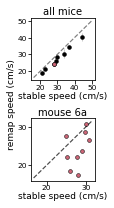

In [101]:
''' plot remap vs. stable speed example mouse and all mice '''
gs = gridspec.GridSpec(2, 1, hspace=0.6)
f = plt.figure(figsize=(1.15, 3))
PT_SIZE = 15
PT_LW = 0.5
UNITY_WIDTH = 1.2
SEM_WIDTH = 1

N_mice_restricted = 0
N_sess_restricted = 0

i = -1
ax0 = plt.subplot(gs[0])
for m, session in zip(mice, sessions):
    i += 1
    
    # get data
    avg_stable = mean_speed_stable[i]
    avg_remap = mean_speed_remap[i]
    sem_s = sem_stable[i]
    sem_r = sem_remaps[i]
    idx = avg_stable > 0
    
    # show data
    print(avg_stable)
    print(avg_remap)
    
    if any(idx):
        N_mice_restricted += 1
        N_sess_restricted += np.sum(idx)
    
    # plot it
    ax0.vlines(avg_stable[idx], avg_remap[idx] - sem_r[idx], avg_remap[idx] + sem_r[idx], 
              colors='k', lw=SEM_WIDTH, linestyles='solid', alpha=0.2, zorder=1)
    ax0.hlines(avg_remap[idx], avg_stable[idx] - sem_s[idx], avg_stable[idx] + sem_s[idx], 
              colors='k', lw=SEM_WIDTH, linestyles='solid', alpha=0.2, zorder=1)
    ax0.scatter(avg_stable[idx], avg_remap[idx], s=PT_SIZE, lw=PT_LW, 
                facecolors='k', edgecolors='k', zorder=2)

# plot unity
ax0.set_xticks([20, 30, 40, 50])
ax0.set_yticks([20, 30, 40, 50])
xlims = ax0.get_xlim()
ylims = ax0.get_ylim()
min_speed = np.min([xlims[0], ylims[0]])
max_speed = np.max([xlims[1], ylims[1]])
plt.plot([min_speed, max_speed], [min_speed, max_speed], '--k', lw=UNITY_WIDTH, alpha=0.5)

ax0.set_title('all mice', fontsize=10, pad=3)
ax0.set_xlabel('stable speed (cm/s)', fontsize=9, labelpad=1)
ax0.tick_params(axis='both', which='major', labelsize=7.5, pad=0.5)
# ax0.set_ylabel('remap speed (cm/s)')

# stable vs. remaps
m = 'Seattle'
s = '1010_1' # also try 1006_1
d = data[m][s]

# highlight on the summary plot
stable_idx = d['remap_idx'][0]
remap_idx = d['remap_idx'][1]
avg_speeds = d['avg_speeds']
ax0.scatter(np.mean(avg_speeds[stable_idx]), np.mean(avg_speeds[remap_idx]), s=PT_SIZE, lw=PT_LW, 
                facecolors=cr_color, edgecolors='k', zorder=3)

# plot each pair
ax2 = plt.subplot(gs[1])
ax2.scatter(stable_blocks, remap_speeds, s=PT_SIZE, lw=PT_LW, 
            facecolors=cr_color, edgecolors='k', alpha=1)
xlims = ax2.get_xlim()
ylims = ax2.get_ylim()
min_speed = np.min([xlims[0], ylims[0]])
max_speed = np.max([xlims[1], ylims[1]])
ax2.plot([min_speed, max_speed], [min_speed, max_speed], '--k', lw=UNITY_WIDTH, alpha=0.7)
ax2.set_xticks([20, 30])
ax2.set_yticks([20, 30])
ax2.tick_params(axis='both', which='major', labelsize=7.5, pad=0.5)
ax2.set_xlabel('stable speed (cm/s)', fontsize=9, labelpad=1)
ax2.set_ylabel('remap speed (cm/s)', horizontalalignment='left', fontsize=9, labelpad=1)
ax2.set_title('mouse {}'.format(mice_IDs[mice.index(m)]), fontsize=10, pad=3)

f.savefig(save_folder + 'stableVSremap.png', dpi=400, bbox_inches='tight')
plt.show()

In [102]:
print('n mice >' + str(MIN_REMAPS) + ' remaps = ' + str(N_mice_restricted))
print('n sessions >' + str(MIN_REMAPS) + ' remaps = ' + str(N_sess_restricted))

n mice >3 remaps = 4
n sessions >3 remaps = 8


In [103]:
m = 'Seattle'
s = '1010_1' # also try 1006_1
d = data[m][s]
W = d['kmeans']['W']
trials = np.arange(0, W.shape[0]-1)

# define remaps
remap_idx_unfilt = np.asarray([])
for w in range(W.shape[1]):
    remaps = np.where(np.abs(np.diff(W[:, w])))[0]
    remap_idx_unfilt = np.append(remap_idx_unfilt, remaps)
remap_idx_unfilt = np.unique(remap_idx_unfilt)
remap_idx_unfilt = remap_idx_unfilt.astype(int)

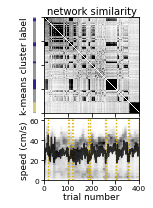

In [105]:
''' plot similarity w/ clusters beside, speed below '''
gs = gridspec.GridSpec(5, 10, hspace=0.2)
f = plt.figure(figsize=(1.9, 3))
DIST_W = 1
SPEED_W = 1.25
REMAP_W = 1.25
CLU_W = 3

# similarity
ax0 = plt.subplot(gs[:3, 1:])
sim = d['similarity']
im = ax0.imshow(sim, clim=[0, 0.6], aspect='auto', cmap='Greys')
ax0.tick_params(labelbottom=False, labelleft=False)
ax0.tick_params(axis='both', which='major', labelsize=7.5, pad=0.5)
ax0.set_ylabel('cluster label', labelpad=24)
ax0.set_title('network similarity', fontsize=10, pad=3)
ax0.set_xticks(np.arange(0, 402, 100))
ax0.set_yticks(np.arange(0, 402, 100))
xlim_ax0 = ax0.get_xlim()
        
# speed by trial
ax1 = plt.subplot(gs[3:, 1:])
ax1.hexbin(obs_trials, speed, gridsize=40, cmap='Greys')
ax1.plot(avg_speed, '-k', linewidth=SPEED_W, alpha=0.8)
ax1.set_ylabel('speed (cm/s)', fontsize=9, labelpad=1)
ax1.set_xlim(xlim_ax0)
ax1.set_xlabel('trial number', fontsize=9, labelpad=1)
# ax1.set_yticks(np.arange(20, 45, 10))
ax1.set_xticks(np.arange(0, 402, 100))
ax1.tick_params(axis='both', which='major', labelsize=7.5, pad=1)

# remaps
ylim_ax1 = ax1.get_ylim()
ax1.vlines(remap_idx, 0, ylim_ax1[1], colors=np.full(remap_idx.shape[0], 'xkcd:gold'), 
           lw=np.full(start_idx.shape[0], REMAP_W), linestyles=np.full(start_idx.shape[0], 'dotted'))
ax1.set_ylim([0, ylim_ax1[1]])
    
# k-means cluster labels
ax2 = plt.subplot(gs[:3, 0])
W = d['kmeans']['W'].copy()
start_idx = np.append([0], remap_idx_unfilt)
end_idx = np.append(remap_idx_unfilt, W.shape[0])
map_colors = []
for i in np.where(W[remap_idx_unfilt, :])[1]:
    map_colors.append(all_map_colors[i])
map_colors.append(all_map_colors[np.where(W[-1, :])[0][0]])
ax2.vlines(np.full(start_idx.shape[0], 1), start_idx, end_idx, 
           colors=map_colors, lw=np.full(start_idx.shape[0], CLU_W), linestyles=np.full(start_idx.shape[0], 'solid'))
ax2.vlines(np.full(start_idx.shape[0], 1), start_idx, end_idx, 
           colors=map_colors, lw=np.full(start_idx.shape[0], CLU_W), linestyles=np.full(start_idx.shape[0], 'solid'))
ax2.set_xlim([0.5, 5])
ax2.set_ylim([W.shape[0], 0])
plt.axis('off')    
ax0.set_ylabel('k-means cluster label', fontsize=9, labelpad=15)
    
f.savefig(save_folder + m + '_' + s + '_sim_speed.png', dpi=400, bbox_inches='tight')
plt.show()

In [110]:
''' add decoder analysis '''
import scipy.stats 
from scipy.ndimage import gaussian_filter1d
normcdf = scipy.stats.norm.cdf
normpdf = scipy.stats.norm.pdf

In [111]:
SMOOTHNESS = 10.0
REGULARIZATION = 1e-4

In [112]:
## REGRESSION MODEL ##

from scipy.linalg import cho_factor, cho_solve
from sklearn.base import BaseEstimator

class CircularRegression(BaseEstimator):
    
    def __init__(self, alpha=0.0, tol=1e-5, max_iter=100):
        self.alpha = alpha
        self.tol = tol
        self.max_iter = max_iter
    
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array
            Independent variables, has shape (n_timepoints x n_neurons)
        y : array
            Circular dependent variable, has shape (n_timepoints x 1),
            all data should lie on the interval [-pi, +pi].
        """
        
        # Convert 1d circular variable to 2d representation
        u = np.column_stack([np.sin(y), np.cos(y)])

        # Randomly initialize weights. Ensure scaling does
        W = np.random.randn(X.shape[1], 2)
        W /= np.max(np.sum(np.abs(X @ W), axis=1))
        
        # Cache neuron x neuron gram matrix. This is used below
        # in the M-step to solve a linear least squares problem
        # in the form inv(XtX) @ XtY. Add regularization term to
        # the diagonal.
        XtX = X.T @ X
        XtX[np.diag_indices_from(XtX)] += self.alpha
        XtX = cho_factor(XtX)

        # Compute model prediction in 2d space, and projection onto
        # each observed u.
        XW = (X @ W)
        t = np.sum(u * XW, axis=1)
        tcdf = normcdf(t)
        tpdf = normpdf(t)

        self.log_like_hist_ = [
            np.log(2 * np.pi) - 
            0.5 * np.mean(np.sum(XW * XW, axis=1), axis=0) +
            np.mean(np.log(1 + t * tcdf / tpdf))
        ]

        for itr in range(self.max_iter):

            # E-step.
            m = t + (tcdf / ((tpdf + t * tcdf)))
            XtY = X.T @ (m[:, None] * u)

            # M-step.
            W = cho_solve(XtX, XtY)
            
            # Recompute model prediction.
            XW = X @ W
            t = np.sum(u * XW, axis=1)
            tcdf = normcdf(t)
            tpdf = normpdf(t)

            # Store log-likelihood.
            self.log_like_hist_.append(
                np.log(2 * np.pi) - 
                0.5 * np.mean(np.sum(XW * XW, axis=1), axis=0) +
                np.mean(np.log(1 + t * tcdf / tpdf))
            )
            
            # Check convergence.
            if (self.log_like_hist_[-1] - self.log_like_hist_[-2]) < self.tol:
                break
    
        self.weights_ = W
    
    def predict(self, X):
        u_pred = X @ self.weights_
        return np.arctan2(u_pred[:, 0], u_pred[:, 1])

    def score(self, X, y):
        """
        Returns 1 minus mean angular similarity between y and model prediction.
        
        score == 1 for perfect prediction
        score == 0 in expectation for random prediction
        score == -1 if prediction is off by 180 degrees.
        """
        y_pred = self.predict(X)
        return np.mean(np.cos(y - y_pred))

In [114]:
# train and test on opposite maps: choose blocks of indices
def train_vs_test_blocks(X, y, train_data_idx, test_data_idx, n_repeats=10, train_pct=0.9):
    test_scores = []    
    test_folds = np.array_split(test_data_idx, n_repeats)

    for i in range(n_repeats):        
        # Get train and test indices
        test_idx = test_folds[i]
        train_idx = np.random.choice(np.setdiff1d(train_data_idx, test_idx),
                                     replace=False, size=int(train_data_idx.size * train_pct))

        # Train model
        model.fit(X[train_idx], y[train_idx])

        # Compute test error
        test_scores.append(model.score(X[test_idx], y[test_idx]))
        
    return np.asarray(test_scores)

In [115]:
''' get X and y '''
dt = 0.02
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A']
        B = d['B']
        
        # only calculate for >=400 spike cells
        keep_idx = np.where(np.sum(B, axis=0) >= 400)[0]
        B = B[:, keep_idx]
        
        # convert spikes to FR and smooth
        t_bin = dt
        X = B / t_bin # convert spike count to FR
        X = gaussian_filter1d(X, SMOOTHNESS, axis=0)
        
        # format position s.t. 0 = -pi = +pi = 400
        y_raw = A[:, 0]
        track_len = 400
        y = (y_raw / np.max(y_raw)) * 2 * np.pi - np.pi
        
        d['X'] = X
        d['y'] = y

In [116]:
''' downsample to match speed and num observations '''
for mouse, session in zip(mice, sessions):
    for s in session:
        d = data[mouse][s]
        speed = d['A'][:, 1]
        y = d['y']
        
        # load map indices and restrict to minimum number of observations
        map_indices = d['idx'].copy()
        obs_thresh = 3000
        if any(np.sum(map_indices, axis=1) < obs_thresh):
            map_indices = map_indices[np.sum(map_indices, axis=1) < obs_thresh, :]      
        n_maps, n_obs = map_indices.shape

        # bin speed into 15cm/s bins
        edges = np.arange(10, np.max(speed), 10)
        speed_idx = np.digitize(speed, edges)

        # list to hold indices for downsampling (one array per map, plus a spot for all maps)
        ds_indices = []
        for m in range(n_maps+1):
            ds_indices.append(np.asarray([]))
        all_obs = np.arange(n_obs)
    
        # match occupancy of each speed bin for each map
        bins, ct = np.unique(speed_idx, return_counts=True)
        for b in bins:
            occupancies = np.sum(map_indices[:, speed_idx == b], axis=1)
            min_occ = np.min(occupancies) 
            if min_occ == 0:
                continue
            
            # within map samples
            for m in range(n_maps):
                ds_idx = ds_indices[m]
                idx = np.where(map_indices[m, :] & (speed_idx == b))[0]
                new_idx = np.append(ds_idx, np.random.choice(idx, min_occ, replace=False))
                ds_indices[m] = new_idx
            
            # across map samples
            ds_idx = ds_indices[-1]
            new_idx = np.append(ds_idx, np.random.choice(all_obs[speed_idx == b], min_occ, replace=False))
            ds_indices[-1] = new_idx
        
        if ds_indices[0].shape[0] == 0:
            print('{} {}: no overlapping speed bins!'.format(mouse, s))
        else:
            print('{} {}: successfully downsampled'.format(mouse, s))
            n_idx = new_idx.shape[0]
            ds_as_array = np.zeros((n_maps+1, n_idx))
            for i, ds in enumerate(ds_indices):
                ds_as_array[i, :] = ds.astype(int)
            d['ds_idx'] = ds_as_array.astype(int)

Seattle 1006_1: successfully downsampled
Seattle 1010_1: successfully downsampled
Juneau 1102_1: successfully downsampled
Juneau 1104_1: successfully downsampled
Juneau 1105_1: successfully downsampled
Toronto 1111_1: successfully downsampled
Toronto 1117_1: successfully downsampled
Kerala 1213_1: successfully downsampled


In [117]:
''' fit model on each map '''
model = CircularRegression(alpha=REGULARIZATION)

# cross-validate the model
for i in trange(len(mice)):
    m = mice[i]
    session = sessions[i]
    for s in session:
        d = data[m][s]
        if 'ds_idx' in d.keys():
            X = d['X']
            y = d['y']
            ds_idx = d['ds_idx']
            n_maps = ds_idx.shape[0]

            # get within map performance
            for j in range(n_maps):
                score = train_vs_test_blocks(X, y, ds_idx[j, :], ds_idx[j, :])
                if j == 0:
                    scores = score
                else:
                    scores = np.row_stack((scores, score))               
            d['scores_same'] = scores

            # get across map performance (don't include all map indices)
            for j in range(n_maps-1):
                for k in range(n_maps-1):
                    if j != k:
                        score = train_vs_test_blocks(X, y, ds_idx[j, :], ds_idx[k, :])
                        if (j == 0) & (k == 1):
                            scores = score
                        else:
                            scores = np.row_stack((scores, score))               
            d['scores_diff'] = scores

100%|█████████████████████| 4/4 [18:56<00:00, 266.44s/it]


In [118]:
# concatenate relevant scores across sessions
same_to_same = []
all_to_all = np.asarray([])
diff_to_diff = []
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        if 'ds_idx' in d.keys():
            scores_same = d['scores_same'].copy()
            scores_diff = d['scores_diff'].copy()            
            
            # get average for each comparison
            same_to_same.append(np.mean(scores_same[:-1, :], axis=1))
            all_to_all = np.append(all_to_all, np.mean(scores_same[-1, :]))
            diff_to_diff.append(np.mean(scores_diff, axis=1))

In [119]:
ds_mice = []
ds_sessions = []
all_colors = []
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        if 'ds_idx' in d.keys():
            ds_mice.append(m)
            ds_sessions.append(s)
            
            if (m=='Seattle') & (s=='1010_1'):
                all_colors.append(cr_color)
            else:
                all_colors.append('k')
print('mice: {}\nsessions: {}'.format(ds_mice, ds_sessions))

mice: ['Seattle', 'Seattle', 'Juneau', 'Juneau', 'Juneau', 'Toronto', 'Toronto', 'Kerala']
sessions: ['1006_1', '1010_1', '1102_1', '1104_1', '1105_1', '1111_1', '1117_1', '1213_1']


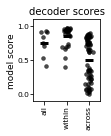

In [124]:
''' compare fits: try comparing same-to-same vs. all-to-all vs. different train/test '''
f, ax = plt.subplots(1, 1, figsize=(1.2, 1.5))

DOT_SIZE = 15
DOT_LW = 0.5
PT_COLOR = 'k'
BAR_SIZE = 8
BAR_WIDTH = 3

# plot data
# train/test all maps
n_pts = all_to_all.shape[0]
j = np.random.randn(n_pts) * .08
ax.scatter(np.full(n_pts, 1)+j, all_to_all, facecolors='k', edgecolors='k', 
           s=DOT_SIZE, lw=DOT_LW, zorder=2, alpha=0.7)   
    
i = -1
N_same = 0
sum_same = 0
N_diff = 0
sum_diff = 0
for m, s in zip(ds_mice, ds_sessions):
    i += 1
    
    # train/test same map
    same_pts = same_to_same[i]
    n_pts = same_pts.shape[0]
    j = np.random.randn(n_pts) * .08
    ax.scatter(np.full(n_pts, 2)+j, same_pts, facecolors=PT_COLOR, edgecolors='k', 
               s=DOT_SIZE, lw=DOT_LW, zorder=2, alpha=0.7)   
    N_same += n_pts
    sum_same += np.sum(same_pts)
    
    # train/test on different maps
    diff_pts = diff_to_diff[i]
    n_pts = diff_pts.shape[0]
    j = np.random.randn(n_pts) * .08
    ax.scatter(np.full(n_pts, 3)+j, diff_pts, facecolors=PT_COLOR, edgecolors='k', 
               s=DOT_SIZE, lw=DOT_LW, zorder=2, alpha=0.7)   
    N_diff += n_pts
    sum_diff += np.sum(diff_pts)
    
# plot means
ax.plot(1, np.mean(all_to_all), '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)
ax.plot(2, sum_same/N_same, '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)
ax.plot(3, sum_diff/N_diff, '_', c='k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=3)

labels = ['all', 'within','across']
ax.set_xlim([0.5, 3.5])
ax.set_ylim([-0.1, 1.1])
ax.set_xticks([1, 2, 3])
ax.set_yticks([0, 0.5, 1])
ax.set_xticklabels(labels, rotation=90)
ax.tick_params(axis='both', which='major', labelsize=7.5, pad=0.5)
ax.set_ylabel('model score', fontsize=9, labelpad=1)
ax.set_title('decoder scores', fontsize=10, pad=5)

f.savefig(save_folder + 'decoder_scores_all.png', dpi=400, bbox_inches='tight')
plt.show()

In [23]:
# get arrays
same_array = np.asarray([])
diff_array = np.asarray([])
for i in range(len(ds_mice)):
    same_array = np.append(same_array, same_to_same[i])
    diff_array = np.append(diff_array, diff_to_diff[i])    

In [24]:
# test for significance
stat, p = stats.kruskal(all_to_all, same_array, diff_array)
print('train/test all maps vs. within map vs. across maps (Kruskal): p = {}'.format(p))

stat_all_same, p_all_same = stats.ranksums(all_to_all, same_array)
print('train/test all maps vs. within map (rank sums): p = {}'.format(p_all_same))

stat_all_diff, p_all_diff = stats.ranksums(all_to_all, diff_array)
print('train/test all maps vs. different maps (rank sums): p = {}'.format(p_all_diff))

stat_same_diff, p_same_diff = stats.ranksums(same_array, diff_array)
print('train/test same maps vs. different maps (rank sums): p = {}'.format(p_same_diff))

train/test all maps vs. within map vs. across maps (Kruskal): p = 1.2159467622443423e-07
train/test all maps vs. within map (rank sums): p = 0.5296506700533425
train/test all maps vs. different maps (rank sums): p = 0.011036728173068493
train/test same maps vs. different maps (rank sums): p = 6.35686164121901e-08


In [25]:
print('mean model performance, sem')
print('train/test on all maps: {}, {}'.format(np.round(np.mean(all_to_all), 2), np.round(stats.sem(all_to_all), 2)))
print('train/test same map: {}, {}'.format(np.round(np.mean(same_array), 2), np.round(stats.sem(same_array), 2)))
print('train/test different maps: {}, {}'.format(np.round(np.mean(diff_array), 2), np.round(stats.sem(diff_array), 2)))

mean model performance, sem
train/test on all maps: 0.66, 0.07
train/test same map: 0.73, 0.03
train/test different maps: 0.4, 0.03


In [27]:
print('N = {} all map models, {} within map models, {} across map models'.format(all_to_all.shape[0], 
                                                                                  same_array.shape[0], 
                                                                                  diff_array.shape[0]))

N = 8 all map models, 27 within map models, 66 across map models
